In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 26 16:09:11 2017

@author: cbothore
"""


import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pickle

def list_of_different_attribute_values(d):
    return set([v for values in d.values() for v in values])
    
def draw_graph(g, node_attribute=None, list_of_values_of_attributes=None):
    """
    Draw the graph g.

    Parameters
    ----------
    g : graph
       A networkx graph
    node_attribute : string 
       The name of the node attribute used to assign colors to the drawing
    list_of_values_of_attributes : list
        A list of all the potential values of node_attribute to assign one color
        per value.
    """
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    
    pos = nx.spring_layout(g, iterations=100)

    
    if node_attribute and list_of_values_of_attributes: 
        # To associate colors to nodes according to an attribute, here college
        # build a color_map, one for each college
        color_map={}
        i=0.0
        for s in list_of_values_of_attributes:
            color_map[s]=i
            i+=1/len(list_of_values_of_attributes)
        color_map[None]=1 # for nodes without values for the attribute node_attribute
        
        # The values supplied to node_color should be in the same order as the nodes 
        # listed in G.nodes(). We take an arbitrary mapping of values color_map and 
        # generate the values list in the correct order
        #values = [color_map[G.node[node].get(node_attribute)] for node in G.nodes()] # for attributes encoded in the graph
        values=[]        
        for node in G.nodes():
            if node in node_attribute:
                if node_attribute[node]:
                    # we arbitrarily take the first value 
                    values.append(color_map[node_attribute[node][0]])
            else:
                values.append(1)
               
        nx.draw_networkx_nodes(g,pos, cmap=plt.get_cmap('jet'), node_color=values)
    else:
        nx.draw_networkx_nodes(g,pos)
       
    nx.draw_networkx_edges(g,pos)
    nx.draw_networkx_labels(g,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)
    plt.show()
    pylab.close()
    del fig

def properties(g):
    """
    Computes simple and classic graph metrics.

    Parameters
    ----------
    g : graph
       A networkx graph
    """
    # networkx short summary of information for the graph g
    print(nx.info(g))
    
    # Draw the degree distribution. Powerlow distribution for a real (complex) network
    plt.figure(num=None)
    fig = plt.figure(1)
    degree_sequence=[d for n, d in g.degree()] # degree sequence
    print("Degree sequence %s" % degree_sequence)
    plt.hist(degree_sequence, bins='auto')  
    plt.title("powerlaw degree distribution")
    plt.ylabel("# nodes")
    plt.xlabel("degree")
    plt.show()
    pylab.close()
    del fig
    
    precomputed_eccentricity = nx.eccentricity(g) # costly step, we save time here!
    print("Graph density %f" % nx.density(g))
    print("Diameter (maximum eccentricity): %d" % nx.diameter(g,precomputed_eccentricity))
    print("Radius (minimum eccentricity): %d" % nx.radius(g,precomputed_eccentricity)) #The radius is the minimum eccentricity.
    print("Mean eccentricity (eccentricity(v) = the maximum distance from v to all other nodes): %s" % np.mean(list(precomputed_eccentricity.values())))
    print("Center is composed of %d nodes (nodes with eccentricity equal to radius)" % len(nx.center(g, precomputed_eccentricity)))
    print("Periphery is composed of %d nodes (nodes with eccentricity equal to the diameter)" % len(nx.periphery(g,precomputed_eccentricity)))
    print("Mean clustering coefficient %f" % np.mean(list(nx.clustering(g).values())))
    total_triangles=sum(nx.triangles(g).values())/3    
    print("Total number of triangles in graph: %d" % total_triangles)



# --------------------- Let's take a quick NetworkX tour ------------------------------#
# load the graph
G = nx.read_gexf("mediumLinkedin.gexf")

# load the profiles. 3 files for each type of attribute
# Some nodes in G have no attributes, or just location, or all of same
# Some nodes may have 2 or more colleges or employers, so we
# use dictionaries to store the attributes
college={}
location={}
employer={}
# The dictionaries are loaded as dictionaries from the disk (see pickle in Python doc)
with open('mediumCollege.pickle', 'rb') as handle:
    college = pickle.load(handle)
with open('mediumLocation.pickle', 'rb') as handle:
    location = pickle.load(handle)
with open('mediumEmployer.pickle', 'rb') as handle:
    employer = pickle.load(handle)

print("Nb of users with one or more attribute college: %d" % len(college))
print("Nb of users with one or more attribute location: %d" % len(location))
print("Nb of users with one or more attribute employer: %d" % len(employer))

# Let's have a look on the graph
draw_graph(G, node_attribute=employer, list_of_values_of_attributes=list_of_different_attribute_values(employer))

# print some properties to understand the type of graph
properties(G)

print("\n\n")
# to see the nodes with the highest degree
# We use sorted with as parameter the list of items (key + value) from our dict 
# The sort key is a lambda function which gives the indice of the data to sort.
# t is a tuple (key, value) from the dict
# Lambda says to sort with the value of the tuple: t[1] 
# to sort the tuple on the key, choose t[0]
sorted_nodes_by_degree=sorted([(n,d) for n, d in G.degree()], key=lambda t: t[1])
print("The 5 nodes with the highest degree are: %s" % str(sorted_nodes_by_degree[-5:]))
print("5 of the nodes with the smallest degree are: %s" % str(sorted_nodes_by_degree[:5]))
print("\n\n")

# To see the neighbors of a node
print("U7912 has %d neighbors" % len([n for n in G.neighbors('U7912')]))
print("U7912 has %d neighbors" % G.degree('U7912'))

if 'U7912' in college:
    print("U7912's college(s): %s" % str(college['U7912']))
print("Her/his neighbors'colleges are:")
for n in G.neighbors('U7912'):
    if n in college:
        print("--- U7912's neighbor %s went in college(s): %s" % (n,str(college[n])))
    else:
        print("--- %s has not filled his/her college profil" % str(n))
print("\n\n")

# Fast examination of all edges is achieved using adjacency iterators.
# Useful to explore the neighbors of each node
# Here, we compute the homophily according to the attribute college
similar_neighbors=0
total_number_neighbors=0 # to verify the number of edges ;-)!!!
for n in G.nodes():
    for nbr in G.neighbors(n):
        total_number_neighbors+=1
        if n in college and nbr in college:
            if len([val for val in college[n] if val in college[nbr]]) > 0:
                similar_neighbors+=1
homophily=similar_neighbors/total_number_neighbors
print("Homophily ('college' attribute), i.e. total proportion of neighbors sharing attributes: %f" % homophily)
print('Is our number of edges (=%d) similar to networkX property (=%d)? No? Normal! why?' % (total_number_neighbors, len(G.edges())))

print("\n\nNow your turn!!! ")

# --------------------- Now your turn -------------------------------------#
# Lest's us say you are U19886 and you want to work at Google.
# Explore, implement your strategy to be helped in getting this job at Google.

Nb of users with one or more attribute college: 540
Nb of users with one or more attribute location: 811
Nb of users with one or more attribute employer: 730


/Users/qurunlu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 1600x1600 with 1 Axes>

Name: 
Type: Graph
Number of nodes: 811
Number of edges: 1597
Average degree:   3.9383
Degree sequence [8, 10, 4, 1, 4, 5, 2, 2, 1, 1, 1, 1, 3, 4, 8, 2, 1, 7, 16, 3, 3, 1, 2, 5, 1, 20, 6, 3, 6, 3, 1, 1, 8, 1, 9, 17, 1, 1, 1, 4, 1, 2, 1, 1, 1, 3, 6, 5, 5, 4, 1, 1, 4, 2, 1, 1, 1, 1, 10, 3, 4, 5, 1, 1, 3, 1, 1, 3, 10, 3, 2, 2, 5, 1, 1, 1, 10, 3, 1, 2, 2, 3, 2, 1, 3, 10, 2, 1, 4, 3, 5, 3, 1, 5, 9, 3, 3, 1, 4, 7, 1, 6, 1, 2, 2, 6, 1, 6, 1, 1, 6, 8, 1, 1, 1, 2, 3, 1, 6, 3, 58, 2, 2, 1, 1, 1, 2, 9, 2, 1, 5, 1, 1, 2, 1, 1, 1, 3, 4, 6, 1, 2, 9, 1, 3, 1, 1, 4, 5, 5, 2, 4, 1, 1, 5, 3, 1, 1, 1, 1, 1, 4, 1, 2, 2, 1, 3, 1, 3, 5, 5, 8, 2, 3, 5, 1, 1, 3, 1, 5, 2, 3, 1, 2, 1, 2, 9, 1, 1, 1, 1, 3, 1, 1, 1, 6, 9, 1, 1, 1, 1, 9, 1, 1, 1, 1, 3, 17, 1, 1, 7, 11, 1, 1, 16, 3, 1, 2, 1, 16, 2, 2, 8, 6, 1, 6, 3, 2, 3, 2, 1, 6, 3, 1, 1, 2, 6, 5, 1, 1, 2, 18, 1, 1, 1, 2, 2, 11, 2, 1, 1, 5, 1, 3, 1, 1, 1, 2, 1, 6, 1, 1, 1, 1, 2, 2, 4, 1, 3, 1, 1, 1, 3, 9, 1, 1, 1, 1, 5, 1, 1, 1, 22, 1, 4, 9, 11, 3, 4, 8, 2, 4, 4, 

<Figure size 640x480 with 1 Axes>

Graph density 0.004862
Diameter (maximum eccentricity): 19
Radius (minimum eccentricity): 10
Mean eccentricity (eccentricity(v) = the maximum distance from v to all other nodes): 13.241676942046857
Center is composed of 3 nodes (nodes with eccentricity equal to radius)
Periphery is composed of 5 nodes (nodes with eccentricity equal to the diameter)
Mean clustering coefficient 0.347288
Total number of triangles in graph: 1217



The 5 nodes with the highest degree are: [('U7972', 46), ('U8670', 46), ('U1045', 58), ('U7024', 74), ('U27287', 122)]
5 of the nodes with the smallest degree are: [('U8804', 1), ('U27759', 1), ('U7310', 1), ('U22859', 1), ('U1417', 1)]



U7912 has 17 neighbors
U7912 has 17 neighbors
U7912's college(s): ['anhui university']
Her/his neighbors'colleges are:
--- U4456 has not filled his/her college profil
--- U7912's neighbor U7909 went in college(s): ['southwestern university']
--- U7912's neighbor U18928 went in college(s): ['national taiwan university of scienc

In [2]:
with open('mediumCollege.pickle', 'rb') as handle:
    college = pickle.load(handle)

In [3]:
college

{'U22041': ['university of illinois at urbana-champaign'],
 'U27476': ['shanghai jiao tong university'],
 'U4665': ['university of illinois at urbana-champaign'],
 'U1313': ['longwood university'],
 'U8804': ['universit&#xe0; di bologna'],
 'U15946': ['indian institute of technology bombay'],
 'U2136': ['university of illinois at urbana-champaign'],
 'U9721': ['university of illinois at urbana-champaign'],
 'U1380': ['georgetown university'],
 'U2649': ['shanghai university of finance and economics'],
 'U27759': ['southeast university'],
 'U7310': ['university of illinois at urbana-champaign'],
 'U22859': ['indian institute of technology madras'],
 'U2108': ['university of illinois at urbana-champaign'],
 'U11575': ['shanghai jiao tong university'],
 'U25611': ['university of southern maine', 'penn high school'],
 'U24095': ['dalian university of technology'],
 'U2631': ['beihang university'],
 'U3895': ['shanghai jiao tong university'],
 'U13005': ['university of illinois at urbana-ch

In [5]:
G = nx.read_gexf("mediumLinkedin.gexf")

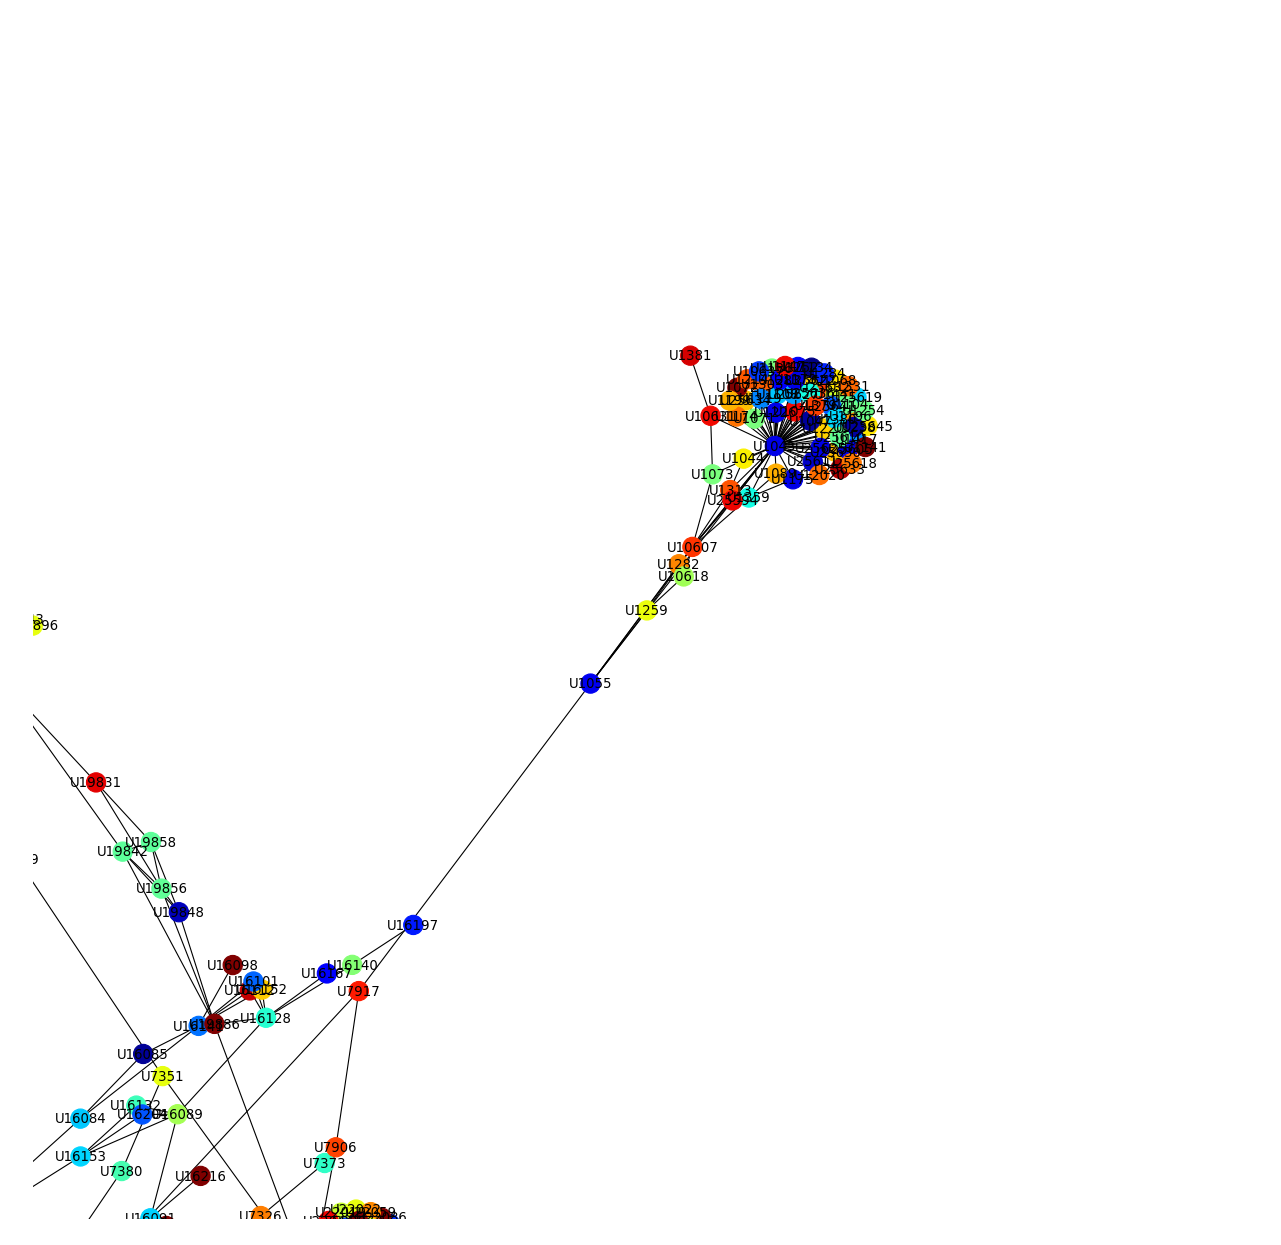

In [6]:
draw_graph(G, node_attribute=employer, list_of_values_of_attributes=list_of_different_attribute_values(employer))

